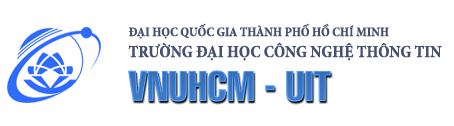



**ĐỒ ÁN CUỐI KỲ MÔN MÁY HỌC - CS114.N21**

---



**BÀI TOÁN: DỰ ĐOÁN GIỚI TÍNH CỦA MỘT NGƯỜI DỰA VÀO HỌ TÊN NGƯỜI ĐÓ**

`Lớp: CS114.N21`

`GV hướng dẫn: TS. Lê Đình Duy, ThS. Phạm Nguyễn Trường An	`

`Thành viên nhóm HKV:`



`1.   Nguyễn Trung Kiên - 21521024`

`2.   Nguyễn Sỹ Hùng - 21522119`

`3.   Phạm Quốc Việt - 21522792`


`Tp. HCM, tháng 7 năm 2023`

**`Mục lục`**

`I. Tổng quan đồ án`

`II. Xây dựng bộ dữ liệu`

`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`

`IV. Kết luận`



##**`I. Tổng quan đồ án`**

###`1.1. Mô tả bài toán`

`Đề tài dự đoán giới tính một người dựa vào họ tên là đề tài hướng đến việc sử dụng họ và tên của một người để có thể phân loại người đó là nam hay nữ. Trong Machine Learning, đây là dạng bài toán có tên gọi Binary Classification, trong đó bài toán chỉ có hai classes, cũng là hai giới tính cần được phân loại.`

###**`1.2. Input và output của bài toán`**

`- Input: Dataset bao gồm họ và tên và giới tính tương ứng, họ tên người cần dự đoán giới tính.`

`- Output: Giới tính được dự đoán của người đó`

###**`1.3. Các thuật toán máy học mà đồ án sử dụng`**

`Trong bài báo cáo, nhóm sẽ sử dụng 4 mô hình classification, đó là: Logistics Regression, SVM, Gaussian Naive Bayes và Decision Tree. Sau khi qua các bước xử lý dữ liệu và trích chọn đặc trưng, data được xử lý sẽ đưa vào các mô hình classification và sau cùng đánh giá từng mô hình bằng confusion matrix và giá trị của các metrics: accuracy, precision, recall và f1-score.`

###**`1.4. Các tiêu chí về một mô hình được đánh giá tốt`**

`Tiêu chí mà nhóm sử dụng để đánh giá một mô hình có thể xem là tốt đó là:`

`f1-score: f1- score là giá trị trung bình điều hòa của precision và recall. Hiểu một cách đơn giản, f1-score cân bằng hai giá trị precision và recall. Đôi khi trong một số trường hợp, tập dữ liệu quá nghiêng về trường hợp positive, giá trị precision sẽ cao nhưng recall thấp, và ngược lại. Hiện tượng này thường được đề cập với tên gọi precision-recall trade-off. Do đó, để tránh việc này, f1-score phải cao thì mới tương ứng với precision cao và recall cao. Qua những nghiên cứu trước đây đã được thực hiện, nhóm hi vọng f1-score của nhóm đạt trên 95%.`


##**`II. Xây dựng bộ dữ liệu`**

`Trước tiên, nhóm sẽ khai báo các package cần thiết sẽ sử dụng cho bài toán như sau: `



In [ ]:
!pip install transformers
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, logging
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

`Đọc file json lấy từ dataset của nhóm trên github`

In [ ]:
data = pd.read_json("https://raw.githubusercontent.com/kiendoo4/final-project/main/dataset/Final_dataset.json")
print(data)

                full_name  gender
0           Ngô Xuân Tùng       1
1       Bùi Dương Thảo Vy       0
2             Lưu Thế Huy       1
3          Nguyễn Thị Vân       0
4         Dương Minh Long       1
...                   ...     ...
28796    Huỳnh Thu Phương       0
28797      Mai Nguyệt Lan       0
28798       Hà Thanh Ngân       0
28799  Phan Thị Tuyết Nhi       0
28800    Vũ Hoàng Thúy Vy       0

[28801 rows x 2 columns]


`Mô tả về bộ dataset`

`- Số lượng nam, nữ giới và còn lại trong bộ data lần lượt là: 16613, 12188 và 0, số lượng nam và nữ giới trong dataset gần bằng nhau để phần nào tránh được tình trạng information bias`

In [ ]:
#Number of males, females and others in data, and the length of data
male = 0
female = 0
other = 0
for line in data["gender"]:
  if line == 1:
    male += 1
  elif line == 0:
    female += 1
  else:
    print(line)
    other += 1
print("Number of males, females and others in data: %s, %s, %s" % (male, female, other))
print("Length of data: %s" % len(data["gender"]))

Number of males, females and others in data: 16613, 12188, 0
Length of data: 28801


`Số lượng họ và tên không trùng trong dataset được lọc ra là 19431. Việc lọc bỏ các dữ liệu trùng lặp cũng sẽ tránh việc information bias. Sau cùng, ta được data chứa một bộ các họ và tên không có bất kỳ bộ đôi họ và tên nào trùng lặp với nhau`

In [ ]:
name_counts = data['full_name'].value_counts()
unique_names = name_counts[name_counts == 1].index
data = data[data['full_name'].isin(unique_names)]
print(data)

                  full_name  gender
1         Bùi Dương Thảo Vy       0
2               Lưu Thế Huy       1
4           Dương Minh Long       1
5            Trần Mai Khanh       0
6      Nguyễn Thị Hồng Diệp       0
...                     ...     ...
28794    Phạm Đoàn Bảo Châu       0
28796      Huỳnh Thu Phương       0
28797        Mai Nguyệt Lan       0
28798         Hà Thanh Ngân       0
28800      Vũ Hoàng Thúy Vy       0

[19431 rows x 2 columns]


`Tách data ra làm 2 phần: X tương ứng với họ và tên và y tương ứng với giá trị đã quy định cho giới tính, 0 là nữ giới, và 1 ứng với nam giới`

In [ ]:
X = data["full_name"]
y = data["gender"]

In [ ]:
print(X)

1           Bùi Dương Thảo Vy
2                 Lưu Thế Huy
4             Dương Minh Long
5              Trần Mai Khanh
6        Nguyễn Thị Hồng Diệp
                 ...         
28794      Phạm Đoàn Bảo Châu
28796        Huỳnh Thu Phương
28797          Mai Nguyệt Lan
28798           Hà Thanh Ngân
28800        Vũ Hoàng Thúy Vy
Name: full_name, Length: 19431, dtype: object


In [ ]:
print(y)

1        0
2        1
4        1
5        0
6        0
        ..
28794    0
28796    0
28797    0
28798    0
28800    0
Name: gender, Length: 19431, dtype: int64


##**`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`**

`Trước tiên, ta chia dữ liệu để xử lý các bước kế tiếp, tỉ lệ 80/20 tương ứng với data để train và data để test`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


####`3.1. Áp dụng PhoBERT`

#####`Quá trình khởi tạo mô hình`

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
print(X_train_encoded)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens

{'input_ids': tensor([[    0, 34811,  1962,  ...,     1,     1,     1],
        [    0,  7298,  1000,  ...,     1,     1,     1],
        [    0,  1962,  1612,  ...,     1,     1,     1],
        ...,
        [    0,  3212,  5309,  ...,     1,     1,     1],
        [    0,  2260, 11109,  ...,     1,     1,     1],
        [    0,  3751,  2378,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
# Pass the encoded inputs through the PhoBERT model
with torch.no_grad():
    X_train_embeddings = phobert(
        input_ids=X_train_encoded['input_ids'],
        attention_mask=X_train_encoded['attention_mask']
    ).pooler_output
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output

`Sau khi đưa qua mô hình PhoBERT, data có dạng text mà ta có lúc đầu đã được convert về dạng numpy array, lúc này là đủ để sử dụng mô hình máy học`

In [ ]:
X_train_embeddings = X_train_embeddings.cpu().numpy()
X_test_embeddings = X_test_embeddings.cpu().numpy()
print(type(X_train_embeddings))

<class 'numpy.ndarray'>


##### `Huấn luyện và đánh giá mô hình qua các mô hình máy học`

######`Sử dụng Logistic Regression`

In [ ]:
# 1. Train a logistic regression model
lr_model = LogisticRegression(max_iter=10000000)
lr_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_embeddings)

# Evaluate the model

print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.94500   0.90811   0.92619      1665
           1    0.93310   0.96040   0.94655      2222

    accuracy                        0.93800      3887
   macro avg    0.93905   0.93425   0.93637      3887
weighted avg    0.93820   0.93800   0.93783      3887

Precision score of using Logistic Regression: 0.9390500655881067
Recall score of using Logistic Regression: 0.9342520738560343
F1-score of using Logistic Regression: 0.9363690858881183


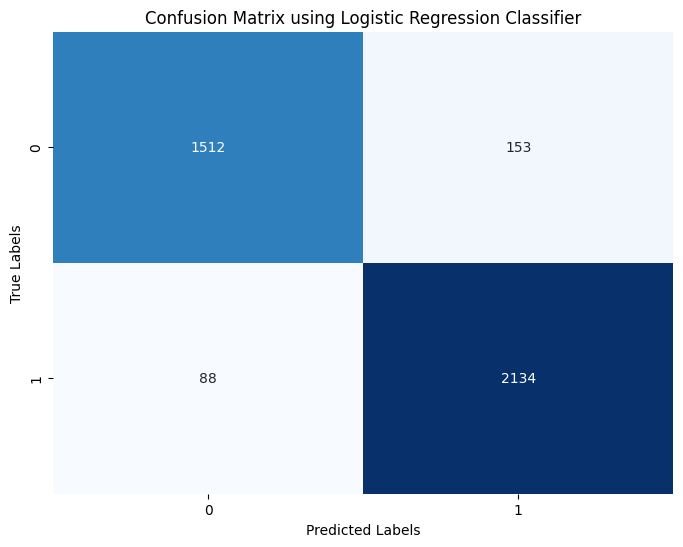

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Logistic Regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Sử dụng SVM`

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0    0.96013   0.89670   0.92733      1665
           1    0.92624   0.97210   0.94862      2222

    accuracy                        0.93980      3887
   macro avg    0.94319   0.93440   0.93797      3887
weighted avg    0.94076   0.93980   0.93950      3887

Precision score of using SVM: 0.943186092558173
Recall score of using SVM: 0.9343969532088344
F1-score of using SVM 0.9379728966685489


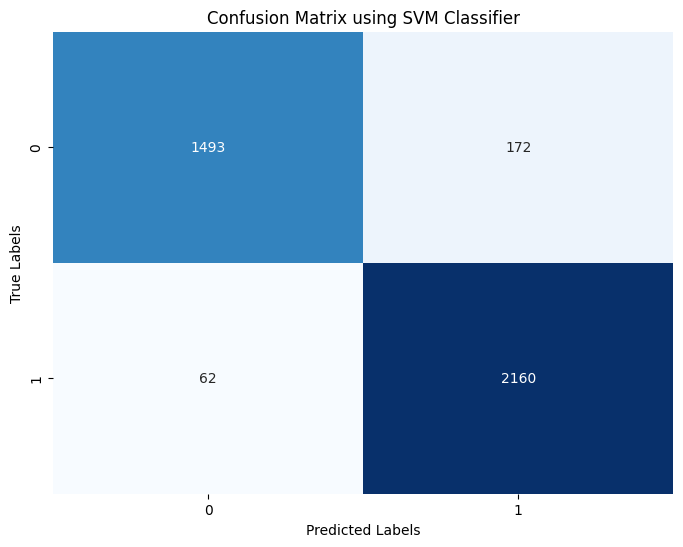

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Sử dụng Gaussian Naive Bayes`

In [ ]:
# 3. Train a Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_embeddings, y_train)
# Predict on the test set
y_pred = nb_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0    0.94751   0.82402   0.88146      1665
           1    0.87987   0.96580   0.92083      2222

    accuracy                        0.90507      3887
   macro avg    0.91369   0.89491   0.90115      3887
weighted avg    0.90884   0.90507   0.90397      3887

Precision score of using GaussianNB model: 0.9136913054213415
Recall score of using GaussianNB model: 0.894910301840995
F1-score of using GaussianNB model 0.9011486321592056


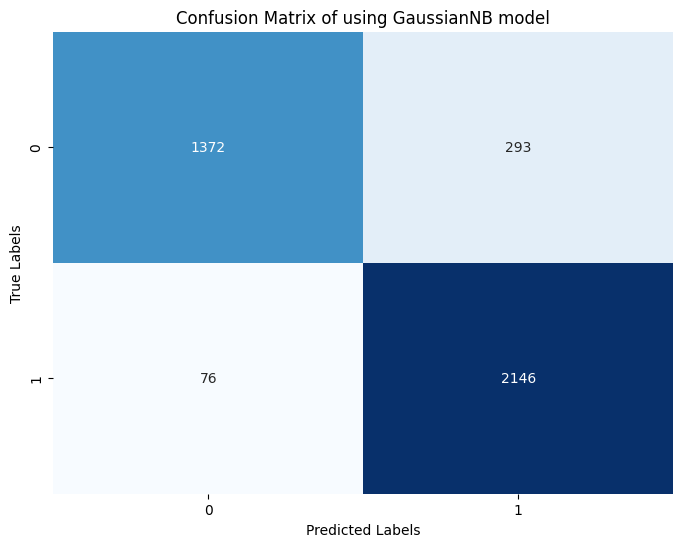

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using GaussianNB model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Sử dụng Decision Tree`

In [ ]:
#4. Train a Decision Tree Classifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0    0.78533   0.79760   0.79142      1665
           1    0.84654   0.83663   0.84156      2222

    accuracy                        0.81991      3887
   macro avg    0.81594   0.81712   0.81649      3887
weighted avg    0.82032   0.81991   0.82008      3887

Precision score of using DecisionTreeClassifier model: 0.8159366419671701
Recall score of using DecisionTreeClassifier model: 0.8171156304819671
F1-score of using DecisionTreeClassifier model 0.8164878104579218


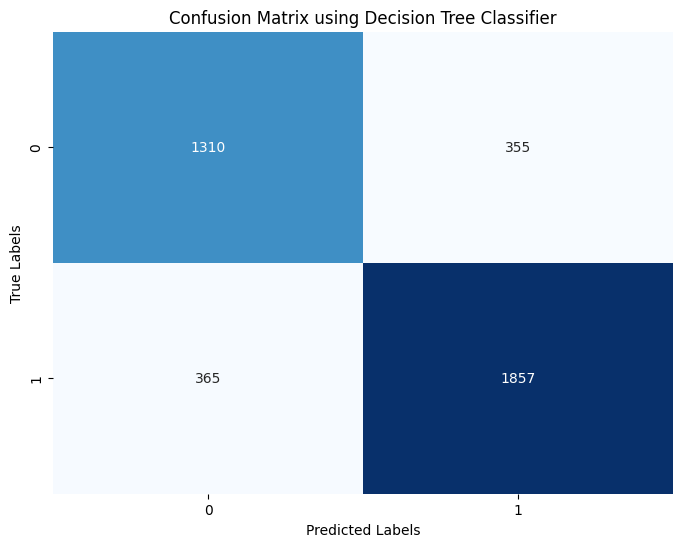

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#####`Trường hợp xoá bỏ họ ra khỏi họ và tên`

###### `Code for PhoBERT`

`Hàm separate_full_name nhằm trả về tên đệm và tên của một người. Trường hợp không có tên đệm thì ta trả về tên đệm là một chuỗi rỗng`

In [ ]:
#Split function to take away the surname
def separate_full_name(full_name):
    fname = full_name.split()
    name = ""
    middle_name = ""
    surname = ""
    if len(fname) > 2:
      name = fname[len(fname) - 1]
      surname = fname[len(fname) - 3]
      middle_name = fname[len(fname) - 2]
    elif len(fname) == 2:
      name = fname[1]
      middle_name = ""
      surname = ""
    return middle_name, name

`Tách họ ra khỏi họ và tên trong dataset, ta được kết quả như sau`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Một lần nữa, áp dụng các mô hình máy học sau đó đánh giá`

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
X_train, X_test, y_train, y_test = train_test_split(X_erase_surname, y, test_size=0.2, random_state=42, shuffle=False)
X_train_encoded = tokenizer.batch_encode_plus(
    X_train,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
print(X_train_encoded)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens

{'input_ids': tensor([[    0,  2883,  6984,  ...,     1,     1,     1],
        [    0,  1000,  2635,  ...,     1,     1,     1],
        [    0,  1612,  1871,  ...,     1,     1,     1],
        ...,
        [    0,  5309,  4429,  ...,     1,     1,     1],
        [    0, 11109,     2,  ...,     1,     1,     1],
        [    0,  2378,  7825,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
# Pass the encoded inputs through the PhoBERT model
with torch.no_grad():
    X_train_embeddings = phobert(
        input_ids=X_train_encoded['input_ids'],
        attention_mask=X_train_encoded['attention_mask']
    ).pooler_output
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output

In [ ]:
X_train_embeddings = X_train_embeddings.cpu().numpy()
X_test_embeddings = X_test_embeddings.cpu().numpy()
print(type(X_train_embeddings))

<class 'numpy.ndarray'>


######`Logistic Regression`

In [ ]:
# 1. Train a logistic regression model
lr_model = LogisticRegression(max_iter=10000000)
lr_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.91048   0.86126   0.88519      1665
           1    0.90009   0.93654   0.91795      2222

    accuracy                        0.90430      3887
   macro avg    0.90528   0.89890   0.90157      3887
weighted avg    0.90454   0.90430   0.90392      3887

Precision score of using Logistic Regression: 0.9052813478332509
Recall score of using Logistic Regression: 0.8989024578133489
F1-score of using Logistic Regression: 0.9015692136777271


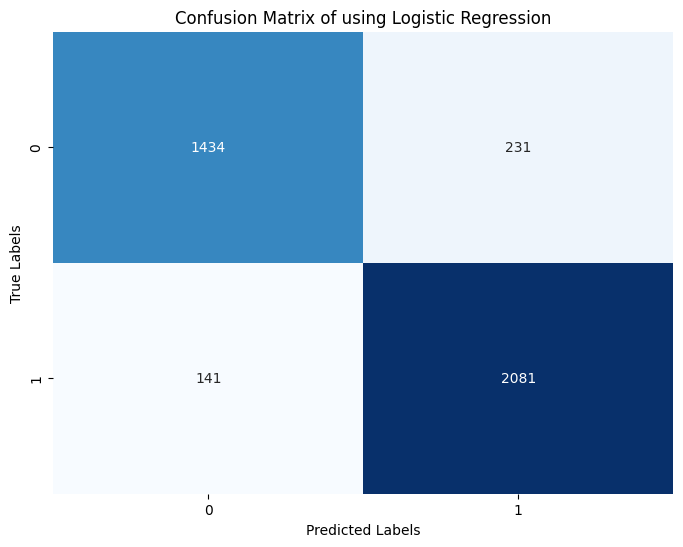

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `SVM`

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0    0.92640   0.86186   0.89297      1665
           1    0.90163   0.94869   0.92456      2222

    accuracy                        0.91150      3887
   macro avg    0.91401   0.90528   0.90876      3887
weighted avg    0.91224   0.91150   0.91103      3887

Precision score of using SVM: 0.9140147262424335
Recall score of using SVM: 0.9052783656744052
F1-score of using SVM 0.9087648336772236


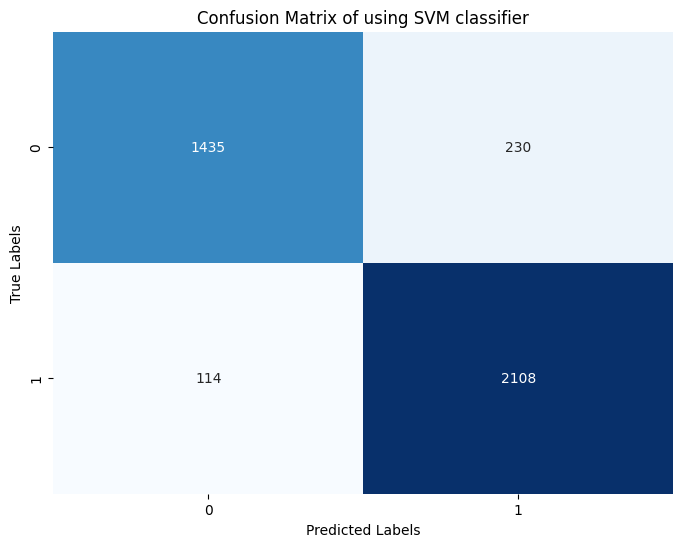

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Gaussian Naive Bayes`

In [ ]:
# 3. Train a Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_embeddings, y_train)
# Predict on the test set
y_pred = nb_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0    0.82647   0.79520   0.81053      1665
           1    0.85077   0.87489   0.86266      2222

    accuracy                        0.84075      3887
   macro avg    0.83862   0.83504   0.83659      3887
weighted avg    0.84036   0.84075   0.84033      3887

Precision score of using GaussianNB model: 0.8386163903435804
Recall score of using GaussianNB model: 0.8350413419720351
F1-score of using GaussianNB model 0.8365938126109173


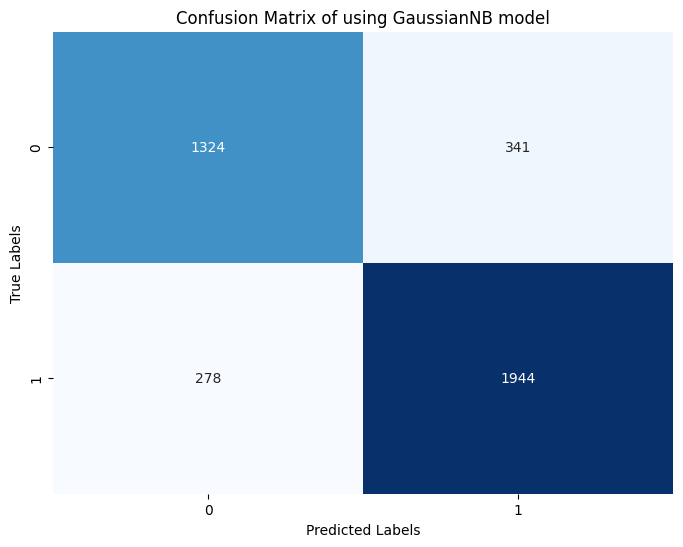

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using GaussianNB model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Decision Tree Classifier`

In [ ]:
#4. Train a Decision Tree Classifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0    0.82233   0.84505   0.83353      1665
           1    0.88143   0.86319   0.87221      2222

    accuracy                        0.85542      3887
   macro avg    0.85188   0.85412   0.85287      3887
weighted avg    0.85611   0.85542   0.85564      3887

Precision score of using DecisionTreeClassifier model: 0.8518799743012342
Recall score of using DecisionTreeClassifier model: 0.8541156818384541
F1-score of using DecisionTreeClassifier model 0.8528727243533791


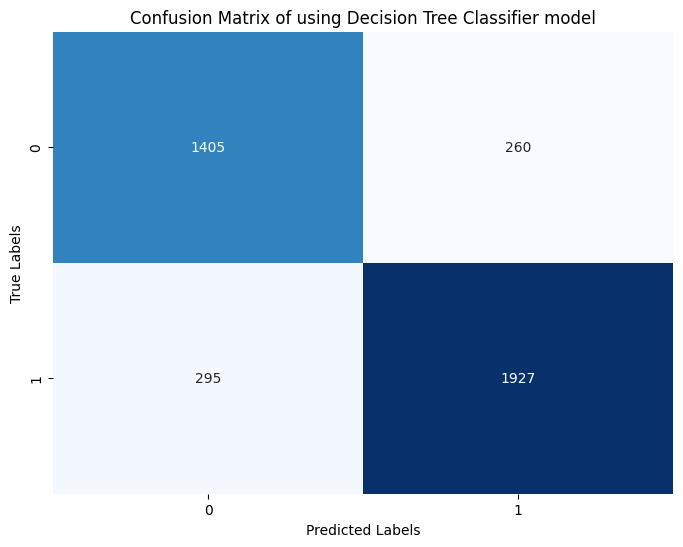

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### `3.2. Bag of words (BoW)`

##### `Quá trình khởi tạo mô hình`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
X = data['full_name']
y = data['gender']

In [ ]:
processed_names = []
for name in X:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

`Xây dựng từ điển từ các từ trong tên đầy đủ`

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [ ]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

Vocabulary size: {} 1575
Vocabualry content:
 {} {'bùi': 59, 'dương': 234, 'thảo': 1156, 'vy': 1404, 'lưu': 588, 'thế': 1169, 'huy': 315, 'minh': 632, 'long': 540, 'trần': 1271, 'mai': 624, 'khanh': 440, 'nguyễn': 711, 'thị': 1172, 'hồng': 404, 'diệp': 204, 'thi': 1078, 'ngọc': 728, 'thái': 1119, 'tường': 1335, 'lê': 568, 'trúc': 1256, 'quỳnh': 967, 'ngô': 720, 'đức': 1564, 'hoàng': 309, 'tấn': 1343, 'đào': 1505, 'hiếu': 290, 'thạch': 1150, 'kim': 473, 'yến': 1459, 'võ': 1411, 'thanh': 1073, 'phạm': 884, 'lệ': 608, 'chi': 105, 'đỗ': 1559, 'nghĩa': 696, 'đinh': 1485, 'dân': 224, 'huỳnh': 330, 'lý': 580, 'chương': 131, 'lương': 589, 'việt': 1396, 'xuân': 1451, 'trịnh': 1278, 'nhật': 784, 'trung': 1238, 'tiến': 1199, 'đạt': 1527, 'giàu': 263, 'mỹ': 678, 'linh': 528, 'phúc': 878, 'trang': 1223, 'hồ': 400, 'nhơn': 772, 'anh': 6, 'duy': 212, 'ngôn': 722, 'cao': 95, 'thiện': 1089, 'huân': 323, 'đình': 1509, 'trương': 1260, 'diệu': 205, 'hiền': 291, 'giang': 257, 'đại': 1524, 'thu': 1101, 'thủ

`Chia bộ dữ liệu thành tập huấn luyện và tập kiểm tra`

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
print(X)

  (0, 59)	1
  (0, 234)	1
  (0, 1156)	1
  (0, 1404)	1
  (1, 588)	1
  (1, 1169)	1
  (1, 315)	1
  (2, 234)	1
  (2, 632)	1
  (2, 540)	1
  (3, 1271)	1
  (3, 624)	1
  (3, 440)	1
  (4, 711)	1
  (4, 1172)	1
  (4, 404)	1
  (4, 204)	1
  (5, 1078)	1
  (5, 728)	1
  (5, 1119)	1
  (6, 1404)	1
  (6, 624)	1
  (6, 711)	1
  (6, 1335)	1
  (7, 568)	1
  :	:
  (19424, 711)	1
  (19424, 1073)	1
  (19424, 1185)	1
  (19424, 1197)	1
  (19425, 1172)	1
  (19425, 728)	1
  (19425, 568)	1
  (19425, 556)	1
  (19426, 884)	1
  (19426, 1498)	1
  (19426, 74)	1
  (19426, 124)	1
  (19427, 330)	1
  (19427, 1101)	1
  (19427, 880)	1
  (19428, 624)	1
  (19428, 519)	1
  (19428, 713)	1
  (19429, 1073)	1
  (19429, 718)	1
  (19429, 353)	1
  (19430, 1404)	1
  (19430, 309)	1
  (19430, 1416)	1
  (19430, 1137)	1


##### `Huấn luyện và đánh giá mô hình qua các mô hình máy học`

######`Huấn luyện mô hình Logistic Regression`

In [ ]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.96219   0.91712   0.93911      1665
           1    0.94000   0.97300   0.95621      2222

    accuracy                        0.94906      3887
   macro avg    0.95110   0.94506   0.94766      3887
weighted avg    0.94951   0.94906   0.94889      3887

Precision score of using Logistic Regression: 0.9510964083175804
Recall score of using Logistic Regression: 0.945057208423545
F1-score of using Logistic Regression: 0.9476642278585545


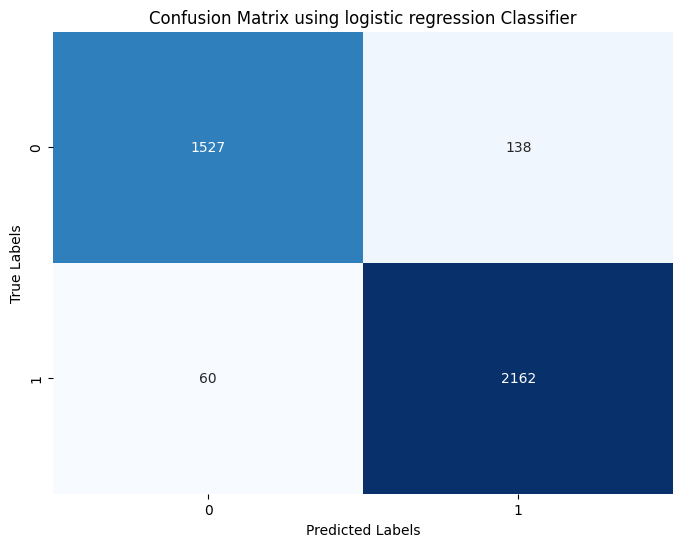

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Huấn luyện mô hình SVM`

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, svm_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, svm_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, svm_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, svm_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

              precision    recall  f1-score   support

           0    0.95975   0.91652   0.93763      1665
           1    0.93949   0.97120   0.95508      2222

    accuracy                        0.94777      3887
   macro avg    0.94962   0.94386   0.94636      3887
weighted avg    0.94817   0.94777   0.94761      3887

Precision score of using SVM: 0.9496173570667784
Recall score of using SVM: 0.9438568181142439
F1-score of using SVM 0.9463564829025357


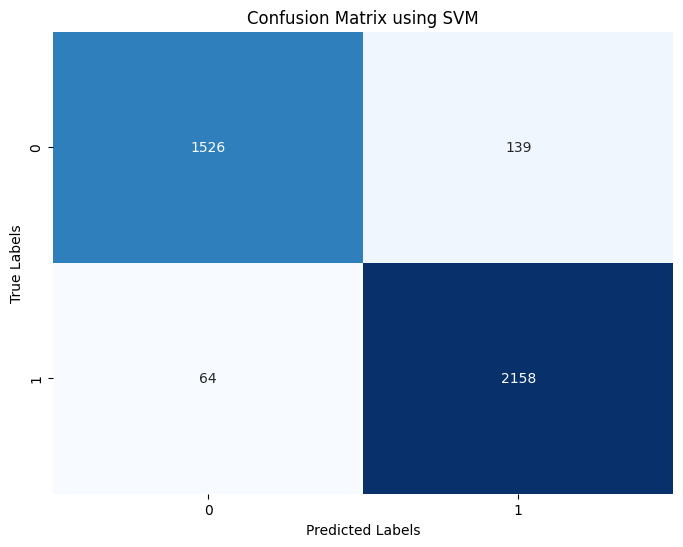

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Decision Tree`

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [ ]:
print(classification_report(y_test, dt_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, dt_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, dt_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, dt_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.89281   0.89550   0.89415      1665
           1    0.92152   0.91944   0.92048      2222

    accuracy                        0.90918      3887
   macro avg    0.90716   0.90747   0.90732      3887
weighted avg    0.90922   0.90918   0.90920      3887

Precision score of using DecisionTreeClassifier model: 0.9071649664135869
Recall score of using DecisionTreeClassifier model: 0.9074687198449575
F1-score of using DecisionTreeClassifier model 0.9073152542899535


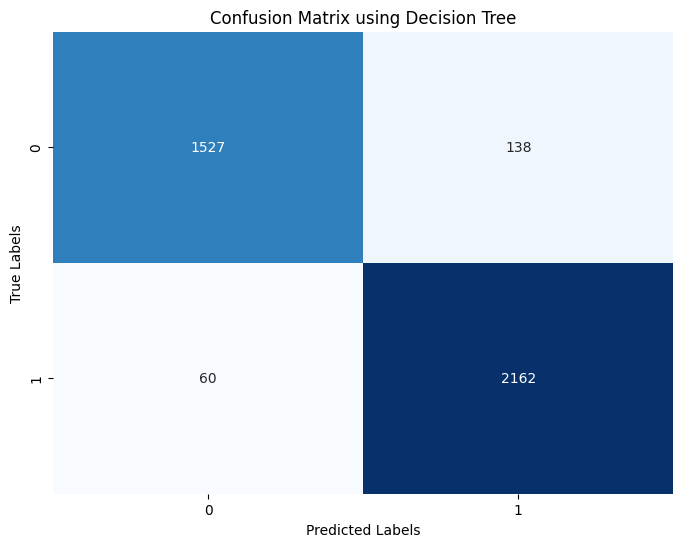

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Gaussian Naive Bayes`

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [ ]:
print(classification_report(y_test, nb_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, nb_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, nb_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, nb_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.53537   0.96817   0.68948      1665
           1    0.93950   0.37039   0.53131      2222

    accuracy                        0.62645      3887
   macro avg    0.73743   0.66928   0.61039      3887
weighted avg    0.76639   0.62645   0.59906      3887

Precision score of using GaussianNB model: 0.7374340128812316
Recall score of using GaussianNB model: 0.6692776034360193
F1-score of using GaussianNB model 0.610394354701093


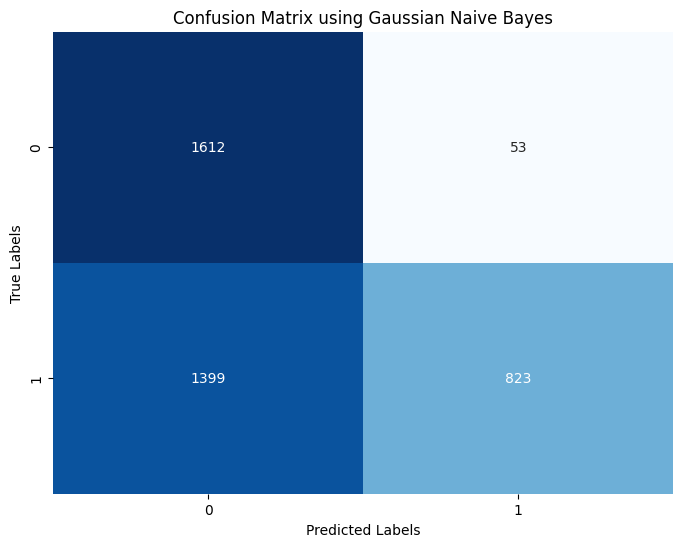

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### `Trường hợp xoá bỏ họ ra khỏi họ và tên`

###### `Code`

`Tách họ ra khỏi họ và tên trong dataset, ta được kết quả như sau`

In [ ]:
#Split function to take away the surname
def separate_full_name(full_name):
    fname = full_name.split()
    name = ""
    middle_name = ""
    surname = ""
    if len(fname) > 2:
      name = fname[len(fname) - 1]
      surname = fname[len(fname) - 3]
      middle_name = fname[len(fname) - 2]
    elif len(fname) == 2:
      name = fname[1]
      middle_name = ""
      surname = ""
    return middle_name, name

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

In [ ]:
y = data['gender']

In [ ]:
processed_names = []
for name in X_erase_surname:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [ ]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

Vocabulary size: {} 1284
Vocabualry content:
 {} {'thảo': 935, 'vy': 1147, 'thế': 947, 'huy': 268, 'minh': 506, 'long': 437, 'mai': 500, 'khanh': 354, 'hồng': 331, 'diệp': 166, 'ngọc': 586, 'thái': 901, 'tường': 1090, 'trúc': 1020, 'quỳnh': 775, 'đức': 1276, 'tấn': 1097, 'hiếu': 246, 'kim': 383, 'yến': 1195, 'thị': 950, 'thanh': 858, 'lệ': 490, 'chi': 82, 'nghĩa': 556, 'dân': 185, 'chương': 103, 'việt': 1141, 'xuân': 1188, 'nhật': 640, 'trung': 1005, 'tiến': 973, 'đạt': 1250, 'giàu': 223, 'mỹ': 542, 'linh': 426, 'phúc': 716, 'trang': 993, 'nhơn': 628, 'anh': 4, 'duy': 174, 'ngôn': 581, 'thiện': 872, 'huân': 276, 'đình': 1233, 'diệu': 167, 'hiền': 247, 'đại': 1247, 'thu': 884, 'thủy': 962, 'khảo': 376, 'xương': 1190, 'tú': 1079, 'sec': 806, 'váy': 1150, 'huỳnh': 283, 'duyên': 175, 'uyên': 1120, 'nam': 545, 'thiên': 864, 'phước': 719, 'tùng': 1078, 'phong': 700, 'như': 629, 'quí': 764, 'quang': 749, 'hào': 296, 'thành': 900, 'bích': 41, 'dũng': 191, 'công': 129, 'triều': 1000, 'phương': 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

###### `Huấn luyện mô hình Logistic Regression`

In [ ]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.93384   0.89009   0.91144      1665
           1    0.92043   0.95275   0.93631      2222

    accuracy                        0.92591      3887
   macro avg    0.92714   0.92142   0.92388      3887
weighted avg    0.92618   0.92591   0.92566      3887

Precision score of using Logistic Regression: 0.9271361058601134
Recall score of using Logistic Regression: 0.9214176823087714
F1-score of using Logistic Regression: 0.923875240521534


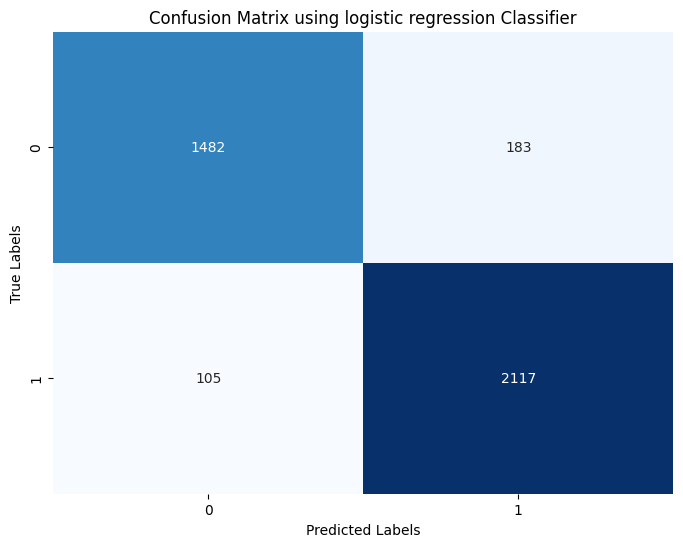

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình SVM`

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, svm_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, svm_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, svm_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, svm_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

              precision    recall  f1-score   support

           0    0.92920   0.89069   0.90954      1665
           1    0.92056   0.94914   0.93463      2222

    accuracy                        0.92411      3887
   macro avg    0.92488   0.91992   0.92209      3887
weighted avg    0.92426   0.92411   0.92388      3887

Precision score of using SVM: 0.9248783514876235
Recall score of using SVM: 0.9199178025910699
F1-score of using SVM 0.9220851167430517


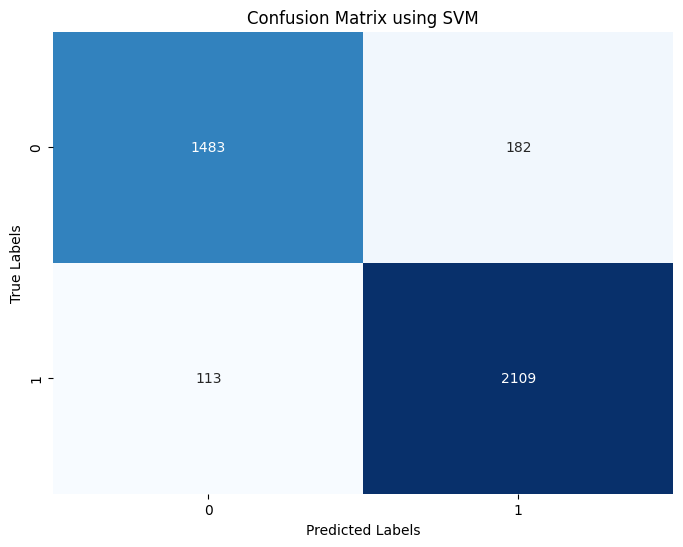

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Decision Tree`

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [ ]:
print(classification_report(y_test, dt_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, dt_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, dt_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, dt_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.85949   0.87808   0.86869      1665
           1    0.90714   0.89244   0.89973      2222

    accuracy                        0.88629      3887
   macro avg    0.88332   0.88526   0.88421      3887
weighted avg    0.88673   0.88629   0.88643      3887

Precision score of using DecisionTreeClassifier model: 0.883315368549688
Recall score of using DecisionTreeClassifier model: 0.8852586610012352
F1-score of using DecisionTreeClassifier model 0.8842073181909842


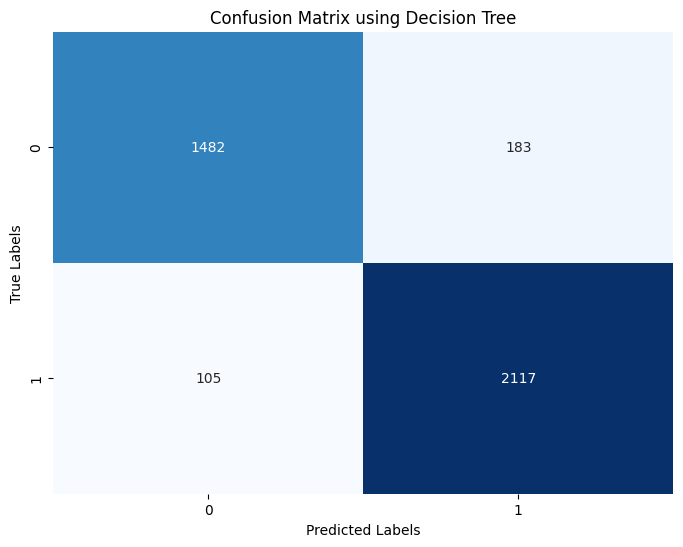

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Gaussian Naive Bayes`

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [ ]:
print(classification_report(y_test, nb_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, nb_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, nb_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, nb_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.54669   0.96697   0.69848      1665
           1    0.94161   0.39919   0.56068      2222

    accuracy                        0.64240      3887
   macro avg    0.74415   0.68308   0.62958      3887
weighted avg    0.77245   0.64240   0.61971      3887

Precision score of using GaussianNB model: 0.7441514460076635
Recall score of using GaussianNB model: 0.6830784429794331
F1-score of using GaussianNB model 0.6295821209869163


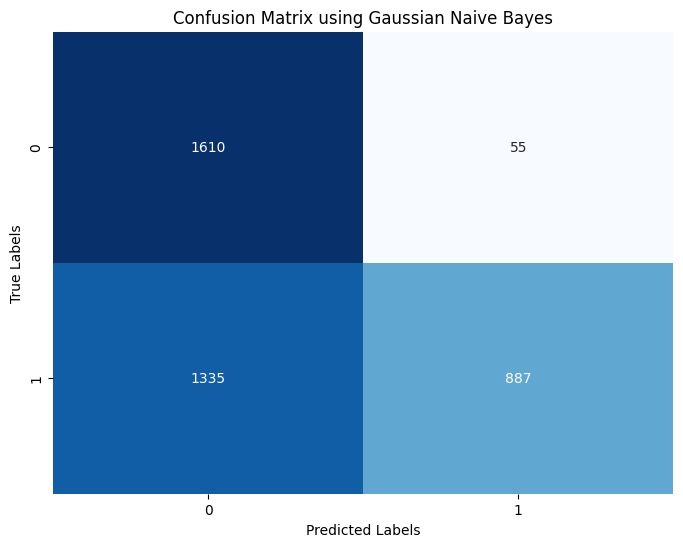

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.3. Bag of n-grams`

##### `Quá trình khởi tạo mô hình`

In [ ]:
X = data["full_name"]
y = data["gender"]

`Bag of n-grams là một mô hình tương tự như Bag of Words, chỉ khác một điều là mô hình này là một tập hợp các cụm phần tử có chuỗi n phần tử liền kề với nhau từ một văn bản cho trước. Nếu n = 1 (unigram) thì ta có thể xem đây là bag of words. Các phần tử có thể là các từ, chữ cái, âm tiết,...`

`Ví dụ: ta có một câu như sau: "Xin chào thế giới."`

`Với unigram (n = 1): "Xin", "chào", "thế", "giới"`

`Với bigram (n = 2): "Xin chào", "chào thế", "thế giới"`
`Với trigram (n = 3): "Xin chào thế", "chào thế giới"`



`Trong thư viện sklearn.feature_extraction.text có một hàm là CountVectorizer(), ta dùng hàm này để áp dụng mô hình Bag of n-grams cho đồ án.`



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

`Ta dùng hàm CountVectorizer() với ngram_range=(2, 3)) - n thuộc khoảng từ 2 -> 3`

In [ ]:
cv = CountVectorizer(ngram_range=(2, 3))

`Biến đổi dữ liệu văn bản thành ma trận đếm`

In [ ]:
X_convert = cv.fit_transform(np.array(X))

`Hiển thị từ điển cụm từ`

In [ ]:
print(cv.vocabulary_)

{'bùi dương': 570, 'dương thảo': 3165, 'thảo vy': 22305, 'bùi dương thảo': 574, 'dương thảo vy': 3167, 'lưu thế': 10450, 'thế huy': 22361, 'lưu thế huy': 10451, 'dương minh': 3017, 'minh long': 11429, 'dương minh long': 3025, 'trần mai': 26768, 'mai khanh': 11054, 'trần mai khanh': 26771, 'nguyễn thị': 14469, 'thị hồng': 23019, 'hồng diệp': 6530, 'nguyễn thị hồng': 14533, 'thị hồng diệp': 23025, 'thi ngọc': 21253, 'ngọc thái': 16798, 'thi ngọc thái': 21254, 'nguyễn mai': 13405, 'mai tường': 11257, 'tường vy': 28873, 'nguyễn mai tường': 13423, 'mai tường vy': 11258, 'lê trúc': 9588, 'trúc quỳnh': 25523, 'lê trúc quỳnh': 9590, 'ngô minh': 15957, 'minh đức': 11633, 'ngô minh đức': 15980, 'hoàng ngọc': 3977, 'ngọc tấn': 16911, 'hoàng ngọc tấn': 4001, 'đào minh': 33022, 'minh hiếu': 11371, 'đào minh hiếu': 33023, 'thạch thị': 22216, 'thị kim': 23151, 'kim yến': 7528, 'thạch thị kim': 22221, 'thị kim yến': 23263, 'võ thị': 30104, 'thị thanh': 24079, 'võ thị thanh': 30157, 'phạm thị': 19596, 

`Làm quen với X đã được chuyển đổi`

In [ ]:
print(X_convert)

  (0, 570)	1
  (0, 3165)	1
  (0, 22305)	1
  (0, 574)	1
  (0, 3167)	1
  (1, 10450)	1
  (1, 22361)	1
  (1, 10451)	1
  (2, 3017)	1
  (2, 11429)	1
  (2, 3025)	1
  (3, 26768)	1
  (3, 11054)	1
  (3, 26771)	1
  (4, 14469)	1
  (4, 23019)	1
  (4, 6530)	1
  (4, 14533)	1
  (4, 23025)	1
  (5, 21253)	1
  (5, 16798)	1
  (5, 21254)	1
  (6, 13405)	1
  (6, 11257)	1
  (6, 28873)	1
  :	:
  (19424, 21146)	1
  (19425, 9390)	1
  (19425, 23697)	1
  (19425, 9464)	1
  (19425, 16584)	1
  (19425, 23746)	1
  (19426, 1167)	1
  (19426, 32540)	1
  (19426, 19947)	1
  (19426, 19948)	1
  (19426, 32541)	1
  (19427, 21488)	1
  (19427, 5074)	1
  (19427, 5078)	1
  (19428, 11093)	1
  (19428, 15797)	1
  (19428, 11094)	1
  (19429, 5596)	1
  (19429, 21058)	1
  (19429, 5602)	1
  (19430, 22133)	1
  (19430, 31117)	1
  (19430, 4145)	1
  (19430, 31129)	1
  (19430, 4148)	1


`Chia data thành 80% bộ train và 20% bộ test`

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_convert, y, test_size=0.2, random_state=42, shuffle=False)

##### `Huấn luyện và đánh giá mô hình qua các mô hình máy học`

###### `SVM`

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.96623   0.75616   0.84838      1665
           1    0.84288   0.98020   0.90637      2222

    accuracy                        0.88423      3887
   macro avg    0.90456   0.86818   0.87737      3887
weighted avg    0.89572   0.88423   0.88153      3887

Precision score of using SVM: 0.9045555148989353
Recall score of using SVM: 0.8681770879790682
F1-score of using SVM 0.8773748952623237


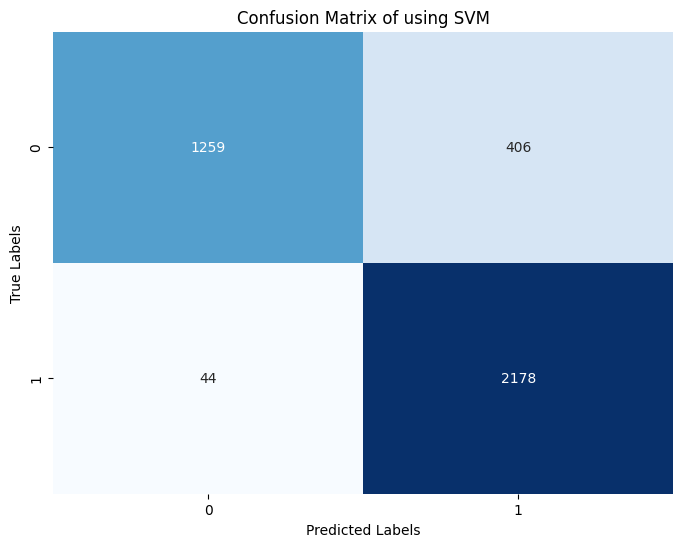

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Logistic Regression`

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



              precision    recall  f1-score   support

           0    0.97246   0.74234   0.84196      1665
           1    0.83601   0.98425   0.90409      2222

    accuracy                        0.88063      3887
   macro avg    0.90424   0.86330   0.87303      3887
weighted avg    0.89446   0.88063   0.87748      3887

Precision score of using Logistic Regression: 0.9042359010820058
Recall score of using Logistic Regression: 0.8632953835924133
F1-score of using Logistic Regression: 0.8730272265545358


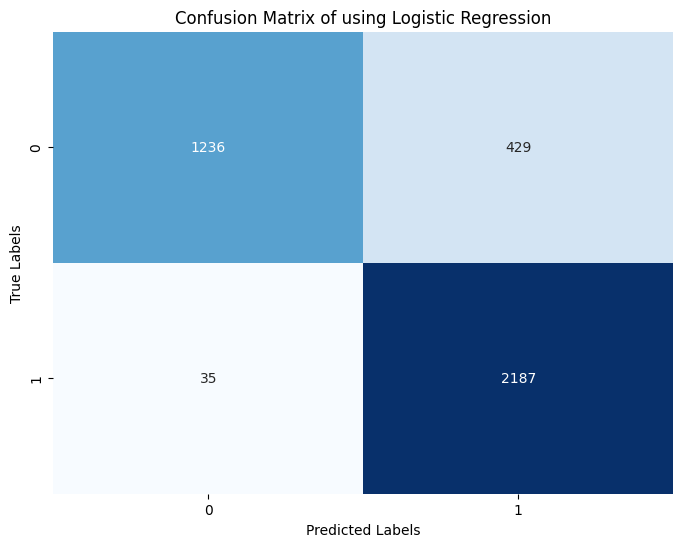

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Gaussian Naive Bayes`

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.70114   0.95676   0.80925      1665
           1    0.95542   0.69442   0.80427      2222

    accuracy                        0.80679      3887
   macro avg    0.82828   0.82559   0.80676      3887
weighted avg    0.84650   0.80679   0.80640      3887

Precision score of using GaussianNB model: 0.8282811614267649
Recall score of using GaussianNB model: 0.8255880993504756
F1-score of using GaussianNB model 0.80675989551093


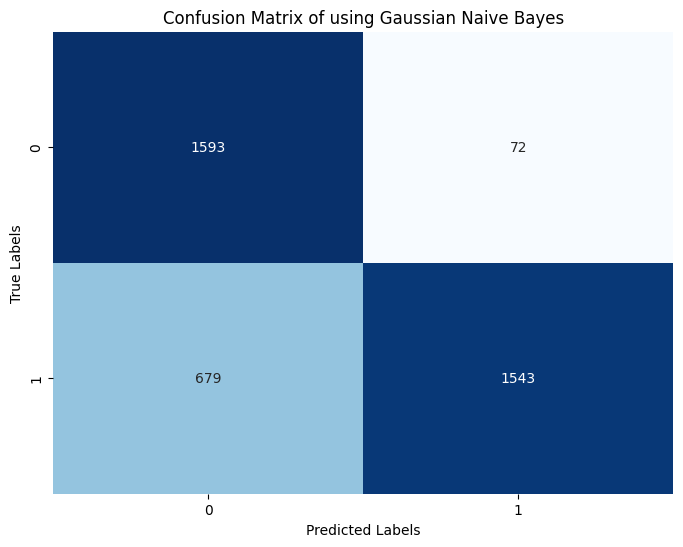

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Decision Tree Classifier`

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.93377   0.77057   0.84436      1665
           1    0.84799   0.95905   0.90011      2222

    accuracy                        0.87831      3887
   macro avg    0.89088   0.86481   0.87223      3887
weighted avg    0.88473   0.87831   0.87623      3887

Precision score of using DecisionTreeClassifier model: 0.8908802321088998
Recall score of using DecisionTreeClassifier model: 0.8648082375805148
F1-score of using DecisionTreeClassifier model 0.87223114645129


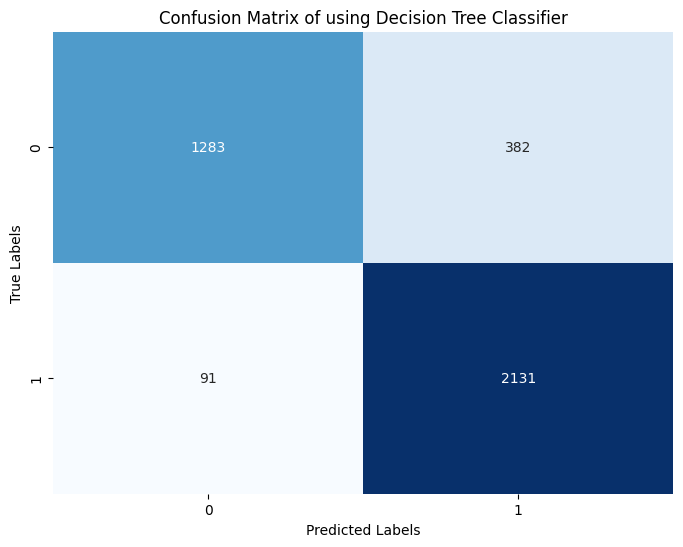

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### `Trường hợp xoá bỏ họ ra khỏi họ và tên`

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`

###### `Code`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Áp dụng các bước bag of n-grams đã trình bày ở phía trên, tổng hợp lại được đoạn code sau:`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
cv = CountVectorizer(ngram_range=(2, 3))
X_convert = cv.fit_transform(np.array(X_erase_surname))
cv.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(X_convert, y, test_size=0.2, random_state=42, shuffle=False)

###### `SVM`

              precision    recall  f1-score   support

           0    0.93624   0.64384   0.76299      1665
           1    0.78373   0.96715   0.86583      2222

    accuracy                        0.82866      3887
   macro avg    0.85999   0.80550   0.81441      3887
weighted avg    0.84906   0.82866   0.82178      3887

Precision score of using SVM: 0.8599895209247067
Recall score of using SVM: 0.8054952792576555
F1-score of using SVM 0.8144116643391135


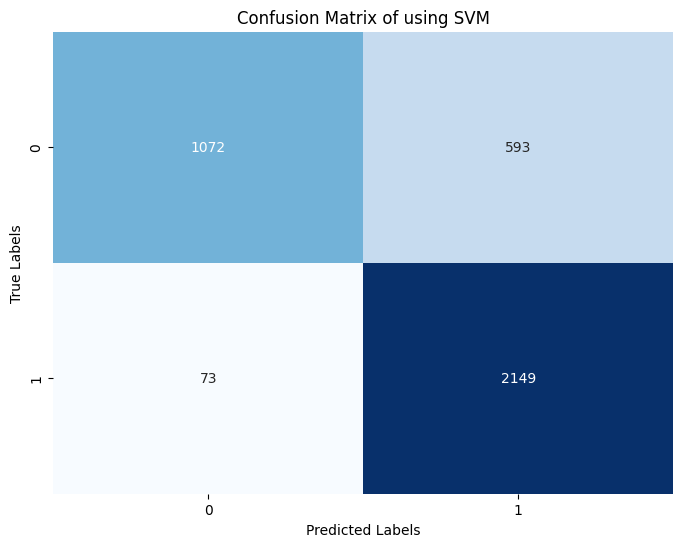

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Logistic Regression`

              precision    recall  f1-score   support

           0    0.93624   0.64384   0.76299      1665
           1    0.78373   0.96715   0.86583      2222

    accuracy                        0.82866      3887
   macro avg    0.85999   0.80550   0.81441      3887
weighted avg    0.84906   0.82866   0.82178      3887

Precision score of using Logistic Regression: 0.8599895209247067
Recall score of using Logistic Regression: 0.8054952792576555
F1-score of using Logistic Regression: 0.8144116643391135


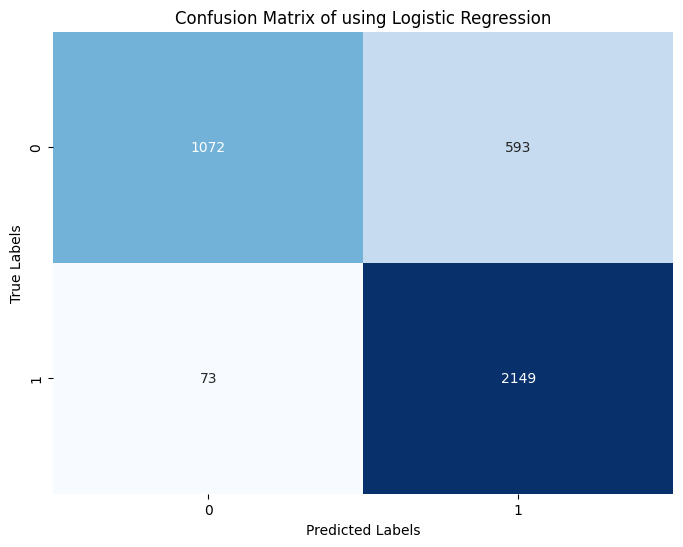

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Gaussian Naive Bayes`

              precision    recall  f1-score   support

           0    0.59089   0.96637   0.73336      1665
           1    0.95189   0.49865   0.65446      2222

    accuracy                        0.69900      3887
   macro avg    0.77139   0.73251   0.69391      3887
weighted avg    0.79726   0.69900   0.68826      3887

Precision score of using GaussianNB model: 0.7713912162273013
Recall score of using GaussianNB model: 0.7325081156764326
F1-score of using GaussianNB model 0.6939116292568306


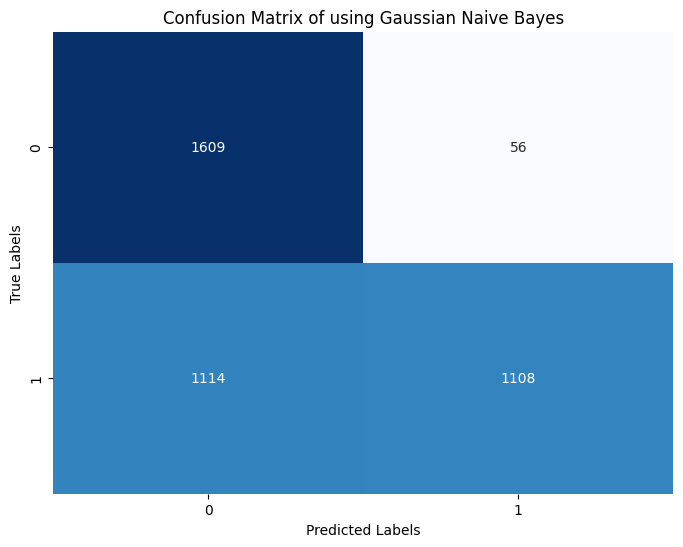

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Decision Tree Classifier`

              precision    recall  f1-score   support

           0    0.92074   0.65586   0.76605      1665
           1    0.78786   0.95770   0.86451      2222

    accuracy                        0.82840      3887
   macro avg    0.85430   0.80678   0.81528      3887
weighted avg    0.84478   0.82840   0.82234      3887

Precision score of using DecisionTreeClassifier model: 0.8542991696910707
Recall score of using DecisionTreeClassifier model: 0.8067758127164067
F1-score of using DecisionTreeClassifier model 0.8152802545379126


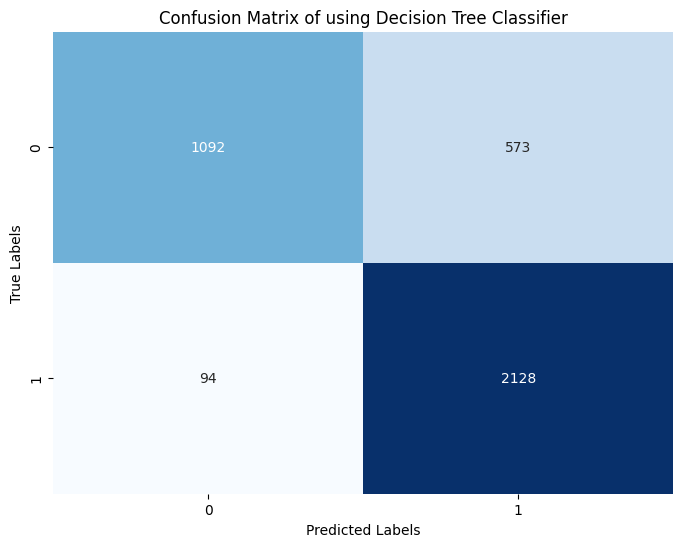

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.4. TF-IDF`

##### `Quá trình khởi tạo mô hình`

In [ ]:
X = data["full_name"]
y = data["gender"]

`Term frequency-inverse document frequency (Tf-Idf) là một trong những phương pháp
được sử dụng rộng rãi hiện nay trong lĩnh vực xử lý dữ liệu văn bản. Tf-Idf thể hiện
mức độ quan trọng của một từ trong văn bản mà văn bản đang xét nằm trong một tập
hợp các văn bản.`

`Trong thư viện sklearn.feature_extraction.text có một hàm là TfidfVectorizer(), ta dùng hàm này để áp dụng mô hình TF-IDF cho đồ án.`



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()

`Biến đổi dữ liệu văn bản thành ma trận đếm`

In [ ]:
tf_v= tfidf.fit_transform(np.array(X))

In [ ]:
print(X)

1           Bùi Dương Thảo Vy
2                 Lưu Thế Huy
4             Dương Minh Long
5              Trần Mai Khanh
6        Nguyễn Thị Hồng Diệp
                 ...         
28794      Phạm Đoàn Bảo Châu
28796        Huỳnh Thu Phương
28797          Mai Nguyệt Lan
28798           Hà Thanh Ngân
28800        Vũ Hoàng Thúy Vy
Name: full_name, Length: 19431, dtype: object


`Hiển thị từ điển từ`

In [ ]:
print(tfidf.vocabulary_)

{'bùi': 59, 'dương': 234, 'thảo': 1156, 'vy': 1404, 'lưu': 588, 'thế': 1169, 'huy': 315, 'minh': 632, 'long': 540, 'trần': 1271, 'mai': 624, 'khanh': 440, 'nguyễn': 711, 'thị': 1172, 'hồng': 404, 'diệp': 204, 'thi': 1078, 'ngọc': 728, 'thái': 1119, 'tường': 1335, 'lê': 568, 'trúc': 1256, 'quỳnh': 967, 'ngô': 720, 'đức': 1564, 'hoàng': 309, 'tấn': 1343, 'đào': 1505, 'hiếu': 290, 'thạch': 1150, 'kim': 473, 'yến': 1459, 'võ': 1411, 'thanh': 1073, 'phạm': 884, 'lệ': 608, 'chi': 105, 'đỗ': 1559, 'nghĩa': 696, 'đinh': 1485, 'dân': 224, 'huỳnh': 330, 'lý': 580, 'chương': 131, 'lương': 589, 'việt': 1396, 'xuân': 1451, 'trịnh': 1278, 'nhật': 784, 'trung': 1238, 'tiến': 1199, 'đạt': 1527, 'giàu': 263, 'mỹ': 678, 'linh': 528, 'phúc': 878, 'trang': 1223, 'hồ': 400, 'nhơn': 772, 'anh': 6, 'duy': 212, 'ngôn': 722, 'cao': 95, 'thiện': 1089, 'huân': 323, 'đình': 1509, 'trương': 1260, 'diệu': 205, 'hiền': 291, 'giang': 257, 'đại': 1524, 'thu': 1101, 'thủy': 1185, 'khảo': 465, 'xương': 1453, 'đoàn': 149

`Hiển thị ma trận đếm`

In [ ]:
print(tf_v)

  (0, 1404)	0.5738614176979726
  (0, 1156)	0.5000308459534245
  (0, 234)	0.4607137875855168
  (0, 59)	0.45650304741741105
  (1, 315)	0.519247657939222
  (1, 1169)	0.6036552957257374
  (1, 588)	0.604964588771033
  (2, 540)	0.677780003800137
  (2, 632)	0.4698743314549274
  (2, 234)	0.5655372481883677
  (3, 440)	0.7685421278631466
  (3, 624)	0.5299820216291684
  (3, 1271)	0.35841603542454187
  (4, 204)	0.7626436618378927
  (4, 404)	0.5171616441016305
  (4, 1172)	0.2747724299474001
  (4, 711)	0.2746244538809126
  (5, 1119)	0.5819258692021193
  (5, 728)	0.40373400312323166
  (5, 1078)	0.70594697922397
  (6, 1335)	0.6153430058766789
  (6, 711)	0.2466739664761255
  (6, 624)	0.47995851920372473
  (6, 1404)	0.574582247572405
  (7, 967)	0.6358796498738645
  :	:
  (19424, 1197)	0.629011203368437
  (19424, 1185)	0.6186114944587469
  (19424, 1073)	0.39850506597125873
  (19424, 711)	0.2507158498295417
  (19425, 556)	0.8480458384472366
  (19425, 568)	0.31919240826545203
  (19425, 728)	0.3463253487503

`Chia data thành 2 phần : 80% cho train và 20% cho test`

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_v, y, test_size=0.2, random_state=42, shuffle=False)

##### `Huấn luyện và đánh giá mô hình qua các mô hình máy học`

###### `SVM`

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.96259   0.91171   0.93646      1665
           1    0.93636   0.97345   0.95455      2222

    accuracy                        0.94700      3887
   macro avg    0.94948   0.94258   0.94550      3887
weighted avg    0.94760   0.94700   0.94680      3887

Precision score of using SVM: 0.9494754136161873
Recall score of using SVM: 0.9425795282230927
F1-score of using SVM 0.945502215243116


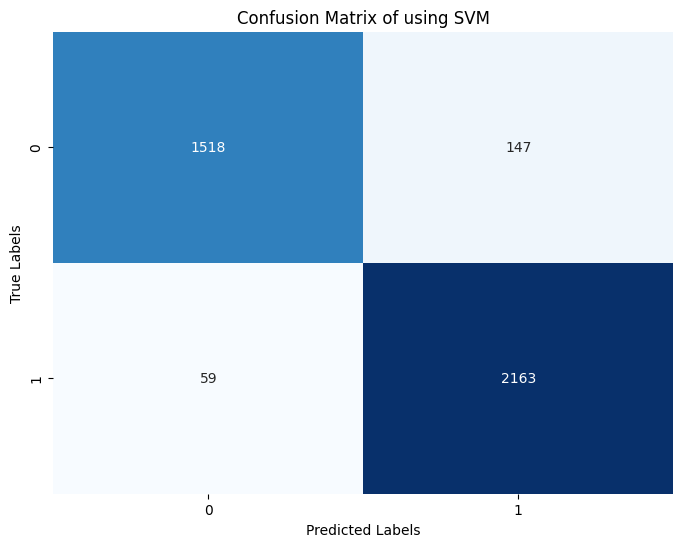

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Logistic Regression`

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



              precision    recall  f1-score   support

           0    0.95924   0.90450   0.93107      1665
           1    0.93138   0.97120   0.95087      2222

    accuracy                        0.94263      3887
   macro avg    0.94531   0.93785   0.94097      3887
weighted avg    0.94331   0.94263   0.94239      3887

Precision score of using Logistic Regression: 0.9453062245545938
Recall score of using Logistic Regression: 0.9378508121082378
F1-score of using Logistic Regression: 0.9409683481610347


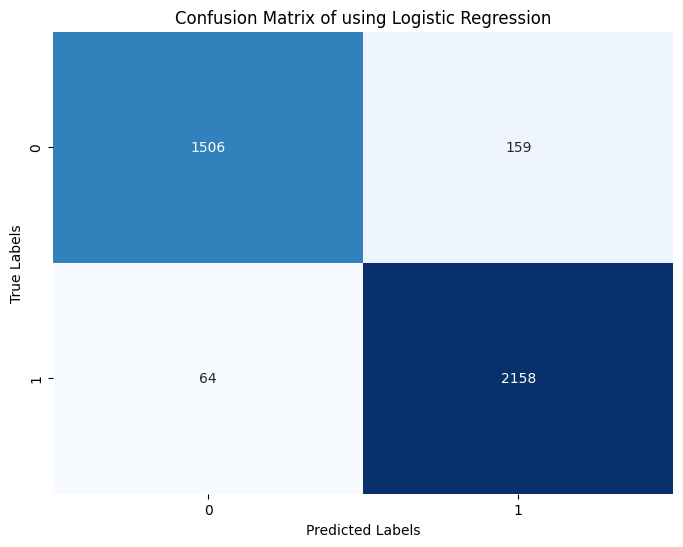

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Gaussian Naive Bayes`

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.52517   0.97117   0.68170      1665
           1    0.94059   0.34203   0.50165      2222

    accuracy                        0.61153      3887
   macro avg    0.73288   0.65660   0.59168      3887
weighted avg    0.76265   0.61153   0.57878      3887

Precision score of using GaussianNB model: 0.7328822846558771
Recall score of using GaussianNB model: 0.6566026872957565
F1-score of using GaussianNB model 0.5916766845318596


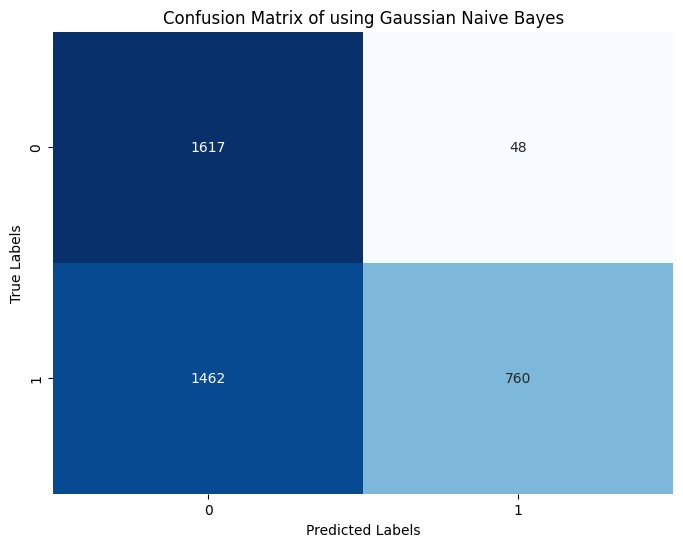

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Decision Tree Classifier`

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.88074   0.88709   0.88390      1665
           1    0.91493   0.90999   0.91245      2222

    accuracy                        0.90018      3887
   macro avg    0.89784   0.89854   0.89818      3887
weighted avg    0.90029   0.90018   0.90022      3887

Precision score of using DecisionTreeClassifier model: 0.8978357711599845
Recall score of using DecisionTreeClassifier model: 0.8985390430934985
F1-score of using DecisionTreeClassifier model 0.8981783644113752


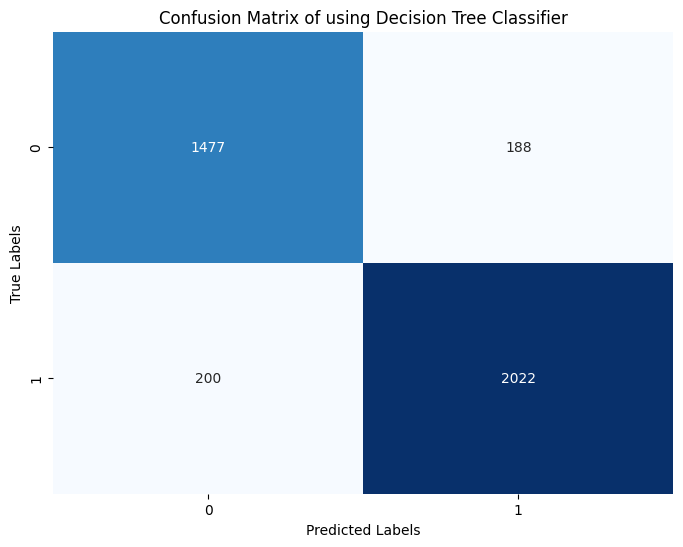

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### `Trường hợp xoá bỏ họ ra khỏi họ và tên`

###### `Code`

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`
`Xoá họ ra khỏi data:`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Tổng hợp lại những bước ở trên trong 1 đoạn code`

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
tfidf = TfidfVectorizer()
tf_v= tfidf.fit_transform(X_erase_surname)
X_train, X_test, y_train, y_test = train_test_split(tf_v, y, test_size=0.2, random_state=42, shuffle=False)

###### `SVM`

              precision    recall  f1-score   support

           0    0.93380   0.88949   0.91110      1665
           1    0.92003   0.95275   0.93610      2222

    accuracy                        0.92565      3887
   macro avg    0.92692   0.92112   0.92360      3887
weighted avg    0.92593   0.92565   0.92540      3887

Precision score of using SVM: 0.9269152399883158
Recall score of using SVM: 0.921117382008471
F1-score of using SVM 0.9236043155618778


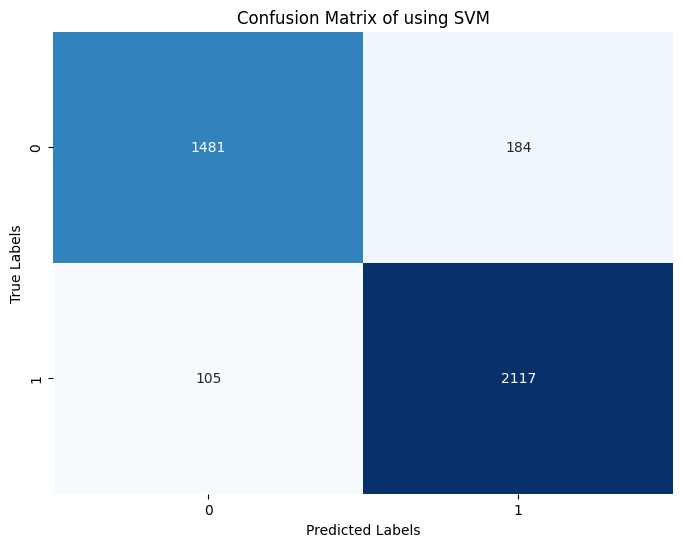

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Logistic Regression`

              precision    recall  f1-score   support

           0    0.93651   0.88589   0.91049      1665
           1    0.91782   0.95500   0.93604      2222

    accuracy                        0.92539      3887
   macro avg    0.92716   0.92044   0.92327      3887
weighted avg    0.92583   0.92539   0.92510      3887

Precision score of using Logistic Regression: 0.9271640028560444
Recall score of using Logistic Regression: 0.9204406927179205
F1-score of using Logistic Regression: 0.9232663224907013


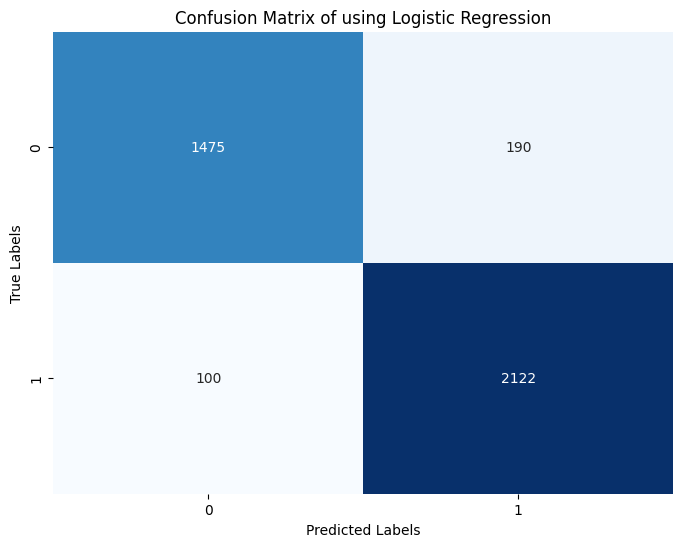

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Gaussian Naive Bayes`

              precision    recall  f1-score   support

           0    0.54161   0.96937   0.69494      1665
           1    0.94377   0.38524   0.54714      2222

    accuracy                        0.63545      3887
   macro avg    0.74269   0.67730   0.62104      3887
weighted avg    0.77151   0.63545   0.61045      3887

Precision score of using GaussianNB model: 0.7426907054009457
Recall score of using GaussianNB model: 0.6773039466108772
F1-score of using GaussianNB model 0.6210402288945285


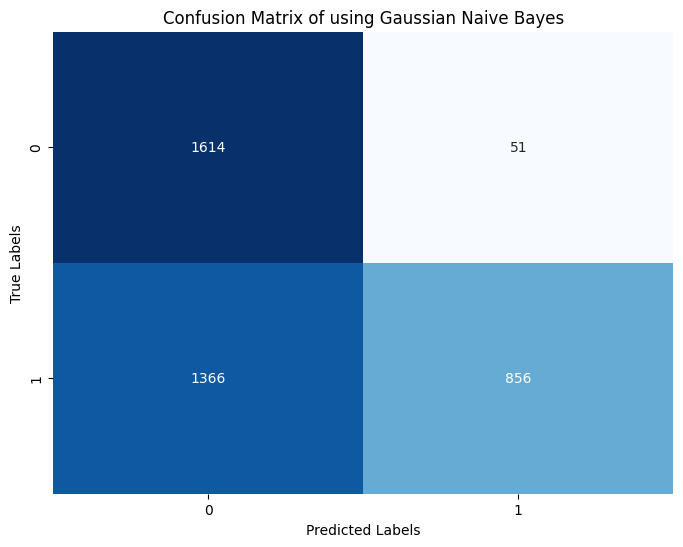

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Decision Tree Classifier`

              precision    recall  f1-score   support

           0    0.88455   0.88348   0.88401      1665
           1    0.91277   0.91359   0.91318      2222

    accuracy                        0.90069      3887
   macro avg    0.89866   0.89854   0.89860      3887
weighted avg    0.90068   0.90069   0.90069      3887

Precision score of using DecisionTreeClassifier model: 0.8986578926876538
Recall score of using DecisionTreeClassifier model: 0.8985374213096986
F1-score of using DecisionTreeClassifier model 0.8985974049707601


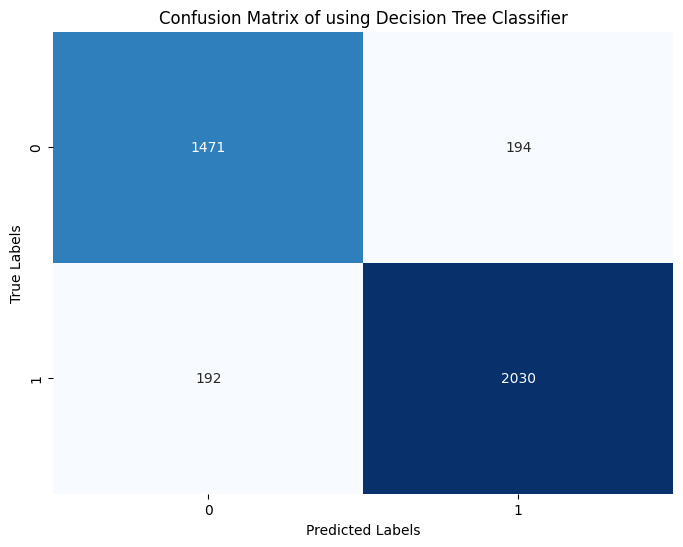

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##**`IV. Kết luận`**


`Sau khi đã xem xét và áp dụng tất cả những gì mà nhóm đã nghiên cứu và thực hiện
được. Kết quả thu được tốt nhất của nhóm đó là f1-score đạt max là 94.77%, sử dụng
mô hình Logistic Regression, trích chọn đặc trưng là Bag-of-words và không bỏ đi phần họ trong họ
và tên.`

`Ngoài ra, khi thử bỏ phần họ trong họ và tên đi thì performance của các mô hình máy
học kết hợp các trích chọn đặc trưng cho văn bản lại bị giảm đi.`



`Danh sách số tên dự đoán nhầm như sau (qua Bag of Word, Logistic Regression)`

In [ ]:
X = data['full_name']
y = data['gender']

In [ ]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
f = []
y_test = np.array(y_test)
Xn_test = np.array(Xn_test)
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        f.append(i)
tempp = [i + X_train.shape[0] for i in f]
print(Xn_test[f]) # Danh sách họ và tên bị máy dự đoán nhầm
print(y_test[f]) # Giới tính thật của các họ và tên trong Xn_test[f]
print(y_pred[f]) # Giới tính bị dự đoán sai của Xn_test[f]

['Nguyễn Hồng Khánh' 'Hồ Nhựt Tiến' 'Cao Thị Anh Tuyết'
 'Trần Nguyễn Thanh Bình' 'Huỳnh Phạm Hồng Thủy' 'Nguyễn Ngọc Hoàng Ngọc'
 'Lê Nhật Khoa' 'Trần Lâm Hân' 'Võ Kim Điền' 'Nguyễn Thái Phi'
 'Ông Dương Thanh Hà' 'Nguyễn Ngọc Lãm' 'Võ Nguyễn Phú Tài'
 'Huỳnh Thanh Thanh' 'Phạm Khánh Hòa' 'Lê Thảo Nhật Quyền'
 'Chung Khánh Gia' 'Phạm Thanh Nhị' 'Lê Hồng Phúc' 'Hoàng Hải Hoàn Châu'
 'Mai Thanh Tòng' 'Nguyễn Việt Thư' 'Ngô Nhật Kim Đang' 'Triệu Thu Nghiêm'
 'Mai Quang Trí' 'Trần HảiThiên Ân' 'Phạm Nguyễn Bảo Anh' 'Phạm Ngọc An'
 'Trương Kim Lâm' 'Lê Chương' 'Thái Ngọc Tiệp' 'Hà Nhật Linh'
 'Hồ Ngọc Thanh' 'Ngô Trần Phúc Khoa' 'H Joan Hwing' 'Trần Duy Duyên'
 'Trần Thanh Thương' 'Phan Lê Minh Hiếu' 'Đặng Hồ Bảo Thy'
 'Thái Nhân Thu Tiền' 'Đậu Quang Cảnh' 'Nguyễn Hồng Diễn' 'Võ Khánh Duy'
 'Chí Nhật Mùi' 'H Sam Niê Kdăm' 'Phan Phi Ngư' 'Trần Liên Thanh'
 'Nguyễn Hửu Đăng' 'Trương Nguyễn Thiên Ân' 'Đậu Phan Hoài Thương'
 'Trần Nguyễn KỲ Anh' 'Nguyễn Phan Thanh Tâm' 'Hoàng Thái Bình Nguyên'

`Vài tên bị dự đoán nhầm ở mỗi giới tính`

In [ ]:
male_test = []
male_pred = []
male_name = []
female_test = []
female_pred = []
female_name = []
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        if y_test[i] == 1:
            male_test.append(y_test[i])
            male_pred.append(y_pred[i])
            male_name.append(Xn_test[i])
        if y_test[i] == 0:
            female_test.append(y_test[i])
            female_pred.append(y_pred[i])
            female_name.append(Xn_test[i])

print("Male:")
print("Danh sách họ tên: ", male_name[0:5])
print("Dự đoán: ", male_pred[0:5])
print("Giới tính đúng: ", male_test[0:5])
print("------------------------------------------------------")
print("Female:")
print("Danh sách họ tên: ", female_name[0:5])
print("Dự đoán: ", female_pred[0:5])
print("Giới tính đúng: ", female_test[0:5])

Male:
Danh sách họ tên:  ['Nguyễn Hồng Khánh', 'Cao Thị Anh Tuyết', 'Huỳnh Phạm Hồng Thủy', 'Nguyễn Ngọc Hoàng Ngọc', 'Trần Lâm Hân']
Dự đoán:  [0, 0, 0, 0, 0]
Giới tính đúng:  [1, 1, 1, 1, 1]
------------------------------------------------------
Female:
Danh sách họ tên:  ['Hồ Nhựt Tiến', 'Trần Nguyễn Thanh Bình', 'Lê Nhật Khoa', 'Võ Kim Điền', 'Nguyễn Thái Phi']
Dự đoán:  [1, 1, 1, 1, 1]
Giới tính đúng:  [0, 0, 0, 0, 0]
